
===================== [XGBoost - GPP] =====================
Best Hyperparameters: {'subsample': 0.8, 'reg_lambda': 0.5, 'reg_alpha': 0.5, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.6}
R² (Coefficient of Determination):   0.6736
RMSE (Root Mean Squared Error):      1.3951
MAE (Mean Absolute Error):           0.7492
ρ (Pearson Correlation Coefficient): 0.8306


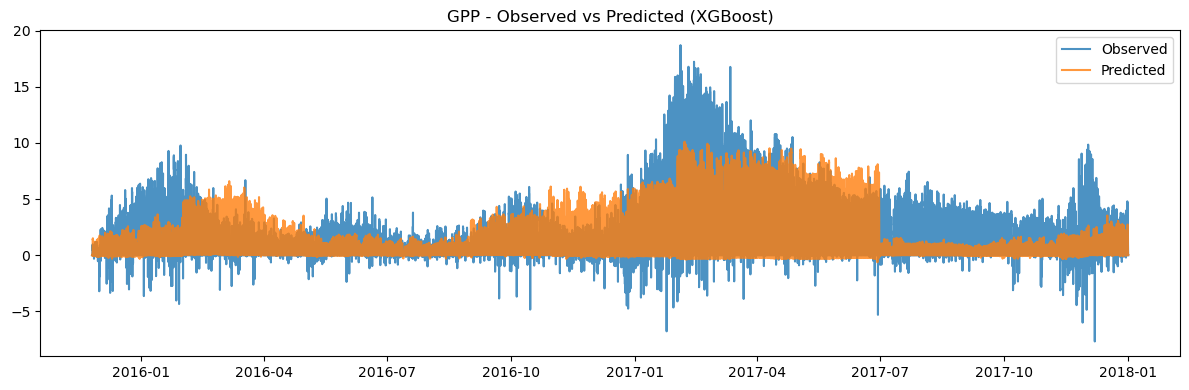

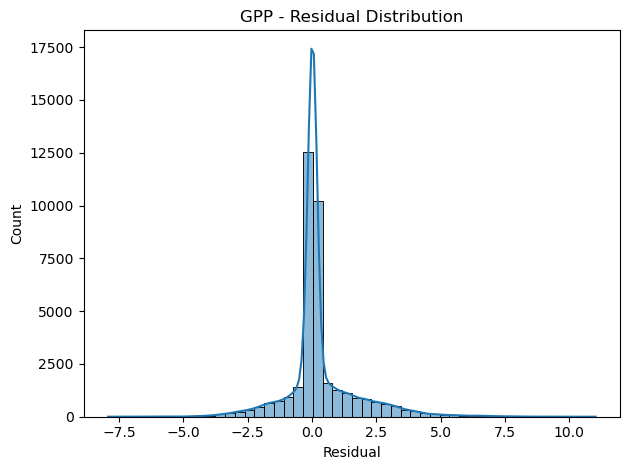

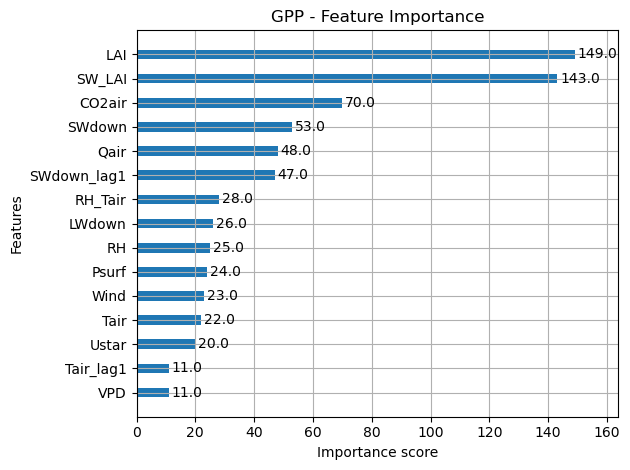

 98%|===================| 36228/36821 [00:17<00:00]        

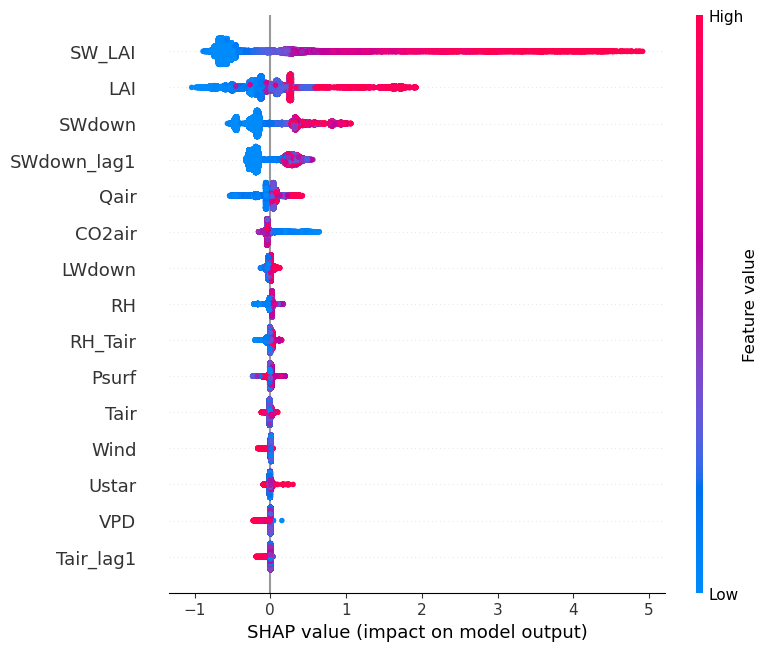


===================== [XGBoost - NEE] =====================
Best Hyperparameters: {'subsample': 1.0, 'reg_lambda': 1.0, 'reg_alpha': 0, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.6}
R² (Coefficient of Determination):   0.6649
RMSE (Root Mean Squared Error):      1.3186
MAE (Mean Absolute Error):           0.9002
ρ (Pearson Correlation Coefficient): 0.8164


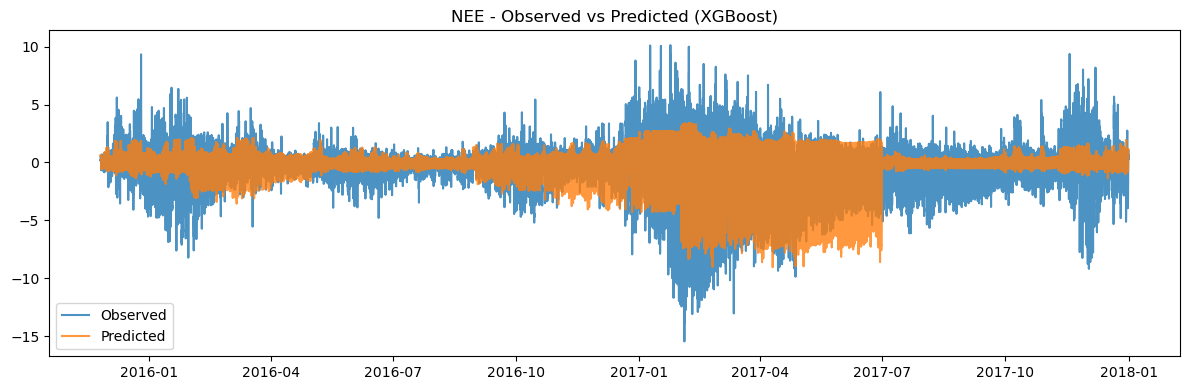

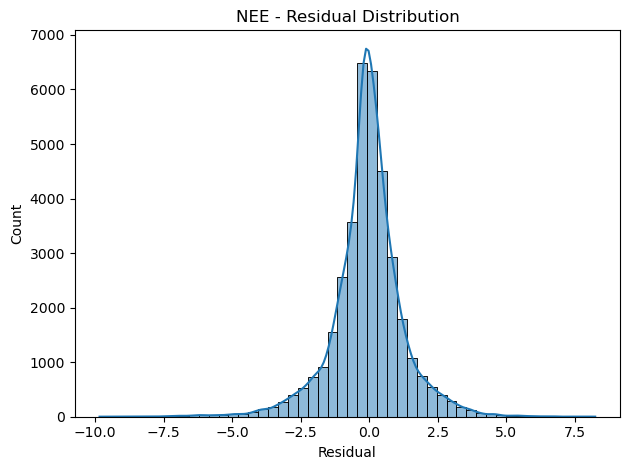

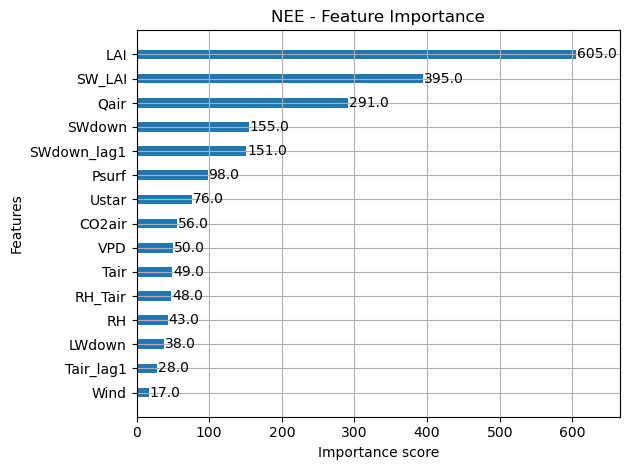

 99%|===================| 36392/36821 [01:01<00:00]        

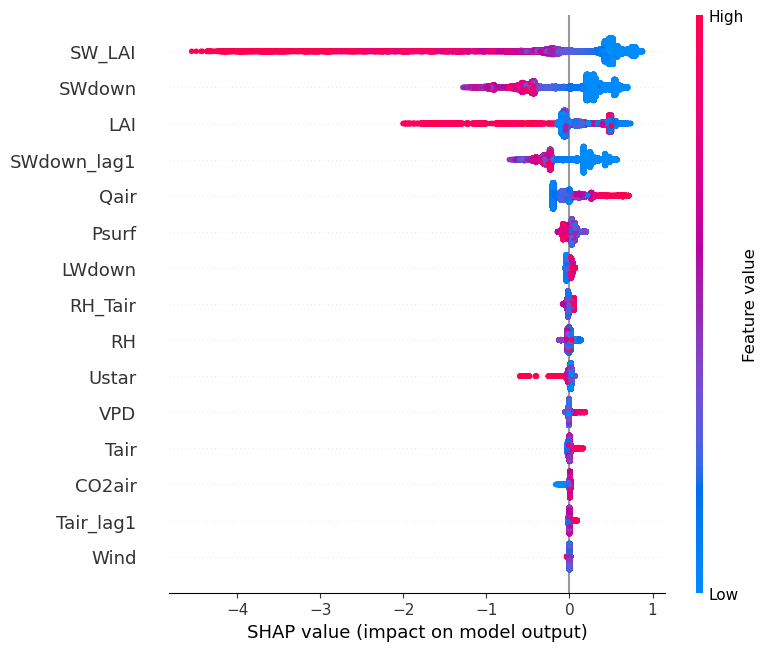

In [9]:
import xgboost as xgb
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from scipy.stats import pearsonr
import shap

# --------------------- 1. Load & Merge Data ---------------------
met_ds = xr.open_dataset("AU-ASM_2011-2017_OzFlux_Met.nc")
flux_ds = xr.open_dataset("AU-ASM_2011-2017_OzFlux_Flux.nc")

met_df = met_ds.to_dataframe().reset_index()
flux_df = flux_ds.to_dataframe().reset_index()

df = pd.merge_asof(met_df.sort_values('time'), flux_df.sort_values('time'), on='time')

# 选择特征和目标
features_raw = ['SWdown', 'LWdown', 'Tair', 'Qair', 'RH', 'Psurf', 'Wind',
                'CO2air', 'VPD', 'LAI', 'Ustar']
target_vars = ['GPP', 'NEE']
df = df[['time'] + features_raw + target_vars].dropna()

# --------------------- 2. Feature Engineering ---------------------
df['SW_LAI'] = df['SWdown'] * df['LAI']
df['RH_Tair'] = df['RH'] * df['Tair']
df['SWdown_lag1'] = df['SWdown'].shift(1)
df['Tair_lag1'] = df['Tair'].shift(1)
df = df.dropna()

df = df.set_index('time').sort_index()
features = features_raw + ['SW_LAI', 'RH_Tair', 'SWdown_lag1', 'Tair_lag1']

# --------------------- 3. Train/Test Split ---------------------
split_idx = int(len(df) * 0.7)
train_df = df.iloc[:split_idx]
test_df = df.iloc[split_idx:]

# --------------------- 4. 模型训练函数 ---------------------
def run_xgb_model(target_var):
    X_train = train_df[features]
    y_train = train_df[target_var]
    X_test = test_df[features]
    y_test = test_df[target_var]

    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'reg_alpha': [0, 0.1, 0.5],
        'reg_lambda': [0.5, 1.0, 2.0]
    }

    base_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    tscv = TimeSeriesSplit(n_splits=3)
    search = RandomizedSearchCV(base_model, param_distributions=param_grid, n_iter=30, cv=tscv, n_jobs=-1, verbose=0)
    search.fit(X_train, y_train)

    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test)

    # 评价指标  （兼容旧版 sklearn）
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # 手动开方
    mae = mean_absolute_error(y_test, y_pred)
    rho, _ = pearsonr(y_test, y_pred)


    print(f"\n===================== [XGBoost - {target_var}] =====================")
    print(f"Best Hyperparameters: {search.best_params_}")
    print(f"R² (Coefficient of Determination):   {r2:.4f}")
    print(f"RMSE (Root Mean Squared Error):      {rmse:.4f}")
    print(f"MAE (Mean Absolute Error):           {mae:.4f}")
    print(f"ρ (Pearson Correlation Coefficient): {rho:.4f}")

    # 可视化
    plt.figure(figsize=(12, 4))
    plt.plot(y_test.index, y_test.values, label="Observed", alpha=0.8)
    plt.plot(y_test.index, y_pred, label="Predicted", alpha=0.8)
    plt.title(f"{target_var} - Observed vs Predicted (XGBoost)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    sns.histplot(y_test - y_pred, bins=50, kde=True)
    plt.title(f"{target_var} - Residual Distribution")
    plt.xlabel("Residual")
    plt.tight_layout()
    plt.show()

    xgb.plot_importance(best_model, height=0.4, max_num_features=15)
    plt.title(f"{target_var} - Feature Importance")
    plt.tight_layout()
    plt.show()

    # SHAP解释
    explainer = shap.Explainer(best_model, X_test)
    shap_values = explainer(X_test)
    shap.plots.beeswarm(shap_values, max_display=15)

# --------------------- 5. 执行模型（GPP + NEE） ---------------------
run_xgb_model("GPP")
run_xgb_model("NEE")
